In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from torch.nn import L1Loss

import cv2

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
src_size = 256

In [5]:
path = Path('./data/dataset')
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
label_fs = os.listdir(path_lbl)
for f in label_fs:
    label = cv2.imread(str(path_lbl / f))
    cv2.imwrite(str(path_lbl / f), np.clip(label, 0, 1))

In [7]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/dataset/images/4400000_002.png'),
 PosixPath('data/dataset/images/0000039_001.png'),
 PosixPath('data/dataset/images/9900031_002.png')]

In [8]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/dataset/labels/4400000_002.png'),
 PosixPath('data/dataset/labels/0000039_001.png'),
 PosixPath('data/dataset/labels/9900031_002.png')]

torch.Size([617, 614])


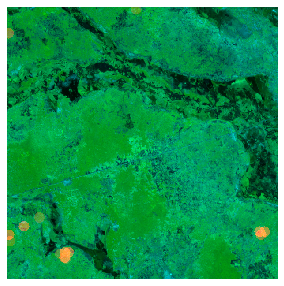

In [9]:
img_f = fnames[0]
img = open_image(img_f)
print(img.size)
img.show(figsize=(5,5))

In [10]:
get_y_fn = lambda x: path_lbl/x.name

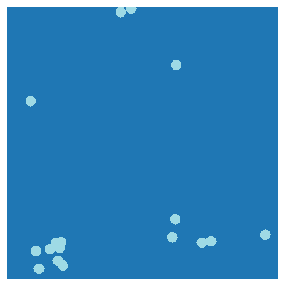

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
codes = ["nothing", "fire"]

In [13]:
size = src_size//2

bs = 8

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

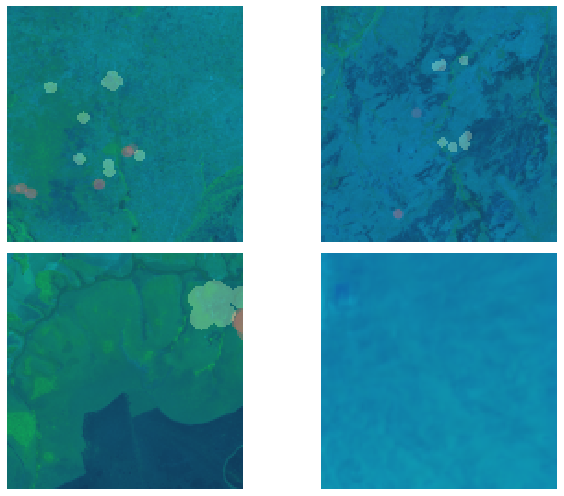

In [16]:
data.show_batch(2, figsize=(10,7))

In [21]:
def _loss_func(preds, targs):
    # Loss multipliers are printed at the end of train_run, to balance the number of annotated pixels
    preds_b = preds[:,1,:,:].unsqueeze(1)
    preds_c = preds[:,0,:,:].unsqueeze(1)
    mask_benign = targs == 0
    masked_preds_benign = preds_c[mask_benign].float() - preds_b[mask_benign].float()
    masked_targs_benign = targs[mask_benign].float()
    if len(masked_targs_benign) > 0:
        loss_benign = L1Loss()(masked_preds_benign, masked_targs_benign) * 1
    else:
        loss_benign = torch.full((), 0., device=torch.device("cuda"))

    mask_clinsig = targs > 0
    masked_preds_clinsig = preds_c[mask_clinsig].float() - preds_b[mask_clinsig].float()
    masked_targs_clinsig = targs[mask_clinsig].float()
    if len(masked_preds_clinsig) > 0:
        loss_clinsig = L1Loss()(masked_preds_clinsig, masked_targs_clinsig) * 5
    else:
        loss_clinsig = torch.full((), 0., device=torch.device("cuda"))
    return loss_benign + loss_clinsig

acc_benign_vals = [0.]

def _acc_dice(preds, targs):
    preds_b = preds[:,1,:,:].unsqueeze(1)
    preds_c = preds[:,0,:,:].unsqueeze(1)
    preds = preds_c - preds_b
    global acc_benign_vals
    mask = (targs == 1) | (preds > 0.5)
    masked_preds = preds[mask].float()
    masked_targs = targs[mask].float()
    if len(masked_targs) == 0:
        out = torch.full((), np.average(acc_benign_vals), device=torch.device("cuda"))
    else:
        iou = ((masked_preds - masked_targs).abs() <= 0.5).float().mean()
        out = 2 * iou / (1 + iou)
        acc_benign_vals.append(out)
        if len(acc_benign_vals) > 200:
            acc_benign_vals = acc_benign_vals[-100:]
    return out

In [22]:
learn = unet_learner(data, models.resnet34, metrics=_acc_dice, loss_func=_loss_func, wd=0.1, bottle=True,
                     blur_final=False, norm_type=NormType.Weight, self_attention=True)
learn.model_dir = "models"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


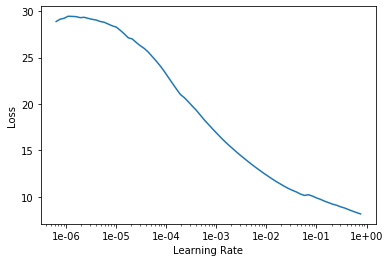

In [19]:
lr_find(learn)
learn.recorder.plot()

In [19]:
lr = 5e-4

epoch,train_loss,valid_loss,_acc_dice,time
0,3.537501,2.863983,0.060752,04:13
1,2.269425,2.010215,0.067938,04:08
2,1.710855,1.568484,0.071268,04:06
3,1.410602,1.334797,0.073302,04:04
4,1.291735,1.252444,0.073904,04:03


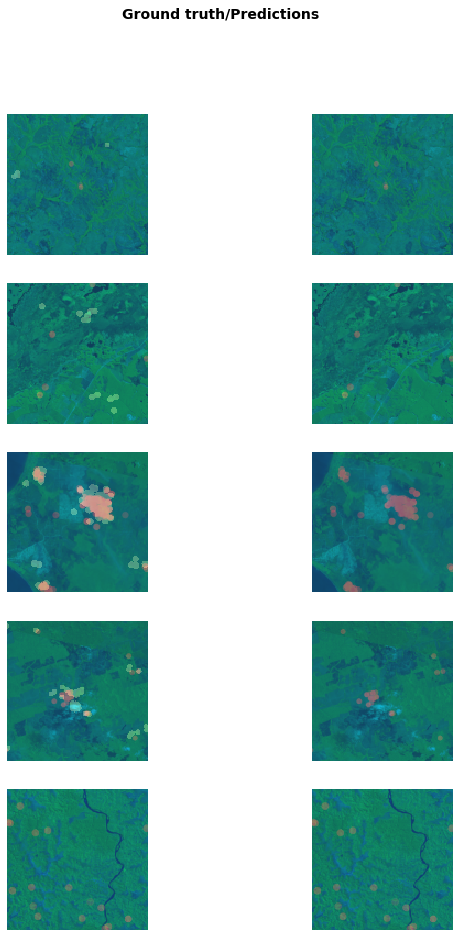

epoch,train_loss,valid_loss,_acc_dice,time
5,1.231572,1.216898,0.073917,04:02
6,1.241399,1.224064,0.073920,04:02
7,1.195045,1.364542,0.073548,04:00
8,1.201610,1.190533,0.073916,04:02
9,1.180947,1.148235,0.073920,04:02


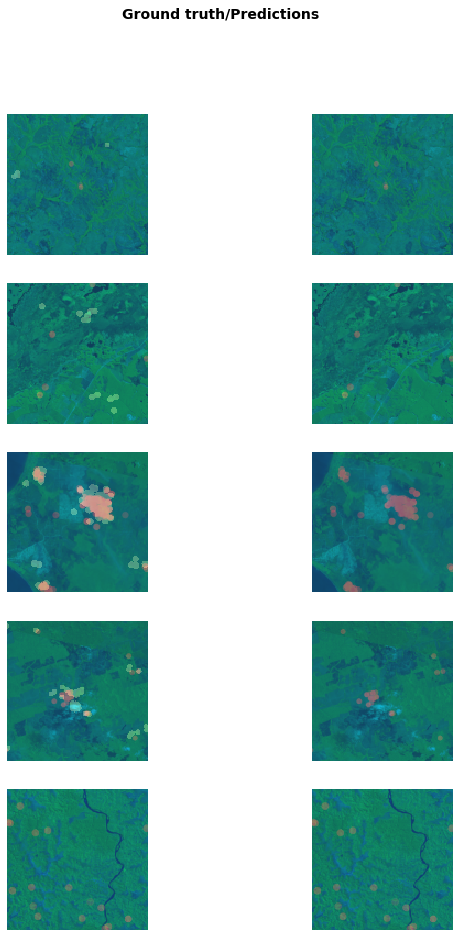

epoch,train_loss,valid_loss,_acc_dice,time
10,1.156319,1.107807,0.073920,04:02
11,1.169866,1.152262,0.073749,04:03
12,1.126150,1.096308,0.073920,04:03
13,1.104383,1.094638,0.073920,03:54


KeyboardInterrupt: 

In [23]:
for i in range(4):
    learn.fit_one_cycle(5 * (i + 1), slice(lr), pct_start=0.8, start_epoch = i * 5, tot_epochs = 20)
    learn.show_results(rows=5, figsize=(10,15))
    plt.show()

In [ ]:
learn.show_results(rows=5, figsize=(10,15))

In [ ]:
learn.save('stage-1')

In [19]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1367 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: data/dataset/images;

Valid: LabelList (341 items)
x: SegmentationItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: SegmentationLabelList
ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128),ImageSegment (1, 128, 128)
Path: data/dataset/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
  

In [20]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


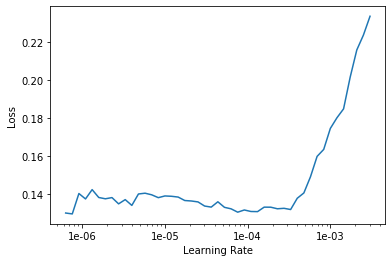

In [21]:
lr_find(learn)
learn.recorder.plot()

In [25]:
for i in range(6):
    learn.fit_one_cycle(5 * (i + 1), slice(lr/500, lr/10), pct_start=0.2, start_epoch = i * 5, tot_epochs = 30)
    learn.show_results(rows=5, figsize=(10,15))
    plt.show()

epoch,train_loss,valid_loss,_acc_dice,time
0,0.110543,0.111937,0.073969,04:43
1,0.099859,0.104774,0.073969,04:44
2,0.097217,0.102620,0.073969,04:45
3,0.097015,0.099127,0.073969,04:45


KeyboardInterrupt: 

In [ ]:
learn.show_results(rows=5, figsize=(15,9))

In [ ]:
learn.save('stage-2')